In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

[PatchCamelyon](https://paperswithcode.com/dataset/pcam) is an image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than ImageNet, trainable on a single GPU.


In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os, datetime, time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import Input 
from tensorflow.keras import callbacks, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, Nadam,Ftrl
from keras.layers import Dense, Conv2D, LSTM, Attention, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization, MaxPooling2D, Dropout
from keras.layers import Reshape, UpSampling2D
from tensorflow.keras.metrics import Accuracy,Precision,Recall,AUC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation,RandomTranslation,RandomFlip,RandomContrast,Resizing

path = '/content/drive/MyDrive/Colab Notebooks/PCam/'

## Load the splited data

In [ ]:
# load our training data
from pickle import load
data = load(open(path + 'data/miniPcam_split.pkl', 'rb'))

# unpack
x_train, y_train, x_val, y_val, x_test, y_test = data.values()

In [ ]:
y_train.shape

(19714, 2)

In [ ]:
# normal sample
label_df = pd.DataFrame(y_train.reshape(-1,2))
sum(label_df.iloc[:,0])

9774.0

In [ ]:
# tumor sample
label_df = pd.DataFrame(y_train.reshape(-1,2))
sum(label_df.iloc[:,1])

9940.0

## generator / augmentation

In [ ]:
batch_size = 64

train_steps_per_epoch = len(x_train) // batch_size
valid_steps_per_epoch = len(x_val) // batch_size

# augmented & normalization
train_datagen = image.ImageDataGenerator(rescale=1.0/255.0,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         rotation_range=45,
                                         channel_shift_range=0.2,
                                         horizontal_flip=True)
# normaliziation only
test_datagen = image.ImageDataGenerator(rescale=1.0/255.0)

# data generator
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
valid_generator = test_datagen.flow( x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [ ]:
# fist batch img, lable
valid_generator.()

64

In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(19714, 96, 96, 3)
(19714, 2)
(6500, 96, 96, 3)
(6500, 2)
(6554, 96, 96, 3)
(6554, 2)


# MobileNetV2
MobileNetV2 is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. It has a drastically lower parameter count than the original MobileNet. MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.

**Why MobileNet2**
* memory efficient inference on device intelligence.
* tradeoff between accuracy, computation, and siz of params.

**Applications**
* Classification
* Object detection
* Fine-grain classification
* Face attributes
* Large-scale geo-localization

**Paper:** 
* [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)
* [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision](https://arxiv.org/pdf/1704.04861.pdf)

## Pipeline

In [ ]:
n_epochs = 20

def train_model(model):
    start = time.time()
    hist = model.fit(train_generator,
                     epochs = n_epochs,
                     verbose = 1, 
                     validation_data = valid_generator,
                     steps_per_epoch = train_steps_per_epoch,
                     validation_steps = valid_steps_per_epoch,
                     shuffle = True,
                     callbacks=callbacks)
    stop = time.time()
    training_time = stop - start
    print(f'Total training time = {training_time}s')
    return hist, model

def eval_model(model):
    score = model.evaluate(test_generator)
    return score

def plot_model(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.plot()
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valication'], loc='lower right')
    plt.show()

def run_all(model):
    hist, model = train_model(model)
    eval_model(model)
    plot_model(hist)
    return model

## M0: mobileNet2NN (75%)

Use mobileNetV2 as backbone

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

Epoch 1/20
308/308 [==============================] - 59s 177ms/step - loss: 0.5366 - accuracy: 0.7353 - auc_14: 0.8071 - precision_14: 0.7321 - recall_14: 0.7339 - true_negatives_14: 14373.0000 - true_positives_14: 14422.0000 - val_loss: 0.6947 - val_accuracy: 0.4972 - val_auc_14: 0.4972 - val_precision_14: 0.4972 - val_recall_14: 0.4972 - val_true_negatives_14: 3214.0000 - val_true_positives_14: 3214.0000
Epoch 2/20
308/308 [==============================] - 54s 175ms/step - loss: 0.4857 - accuracy: 0.7678 - auc_14: 0.8468 - precision_14: 0.7678 - recall_14: 0.7670 - true_negatives_14: 15091.0000 - true_positives_14: 15072.0000 - val_loss: 0.6940 - val_accuracy: 0.4968 - val_auc_14: 0.4968 - val_precision_14: 0.4968 - val_recall_14: 0.4968 - val_true_negatives_14: 3211.0000 - val_true_positives_14: 3211.0000
Epoch 3/20
308/308 [==============================] - 53s 173ms/step - loss: 0.4559 - accuracy: 0.7912 - auc_14: 0.8676 - precision_14: 0.7902 - recall_14: 0.7905 - true_negative

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 2s 22ms/step - loss: 0.5313 - accuracy: 0.7507 - auc_14: 0.8407 - precision_14: 0.7511 - recall_14: 0.7489 - true_negatives_14: 4928.0000 - true_positives_14: 4908.0000


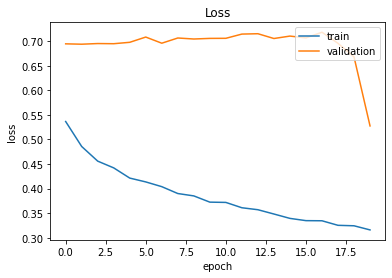

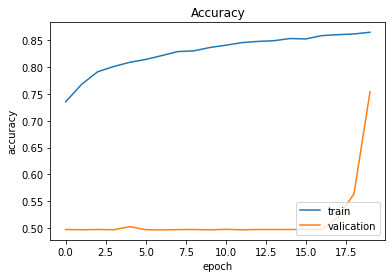

In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'
metrics = ['accuracy',]
n_epochs = 20

# pretrained model
def feature_extractor(inputs):
  features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights=None)(inputs)
  return features

def classifier(inputs):
  # connector
  x = layers.GlobalAveragePooling2D()(inputs)
  x = layers.Flatten()(x)
  
  # additional layers
  x = layers.Dense(1024, activation=act)(x)
  x = layers.Dense(512, activation=act)(x)
  
  output = layers.Dense(2, activation='sigmoid', name='predictions')(x)
  return output

# build model
def mobileNet2NN(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
  n_classes = n_class
  input_shape = input_shape
  model_name = 'mobileNet2NN'

  feature_mobileNet = feature_extractor(inputs)
  class_output = classifier(feature_mobileNet)

  model = Model(inputs=inputs, outputs=class_output, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
  return model

inputs = Input(shape=(96,96,3))
mobileNet2NN = run_all(mobileNet2NN(2))

In [ ]:
m0.summary()

Model: "mobileNet2NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)              

## M1: selu_mobileNet2 (85%)


9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/20
308/308 [==============================] - 76s 225ms/step - loss: 0.3889 - accuracy: 0.8333 - auc_16: 0.9091 - precision_16: 0.8283 - recall_16: 0.8304 - true_negatives_16: 16267.0000 - true_positives_16: 16318.0000 - val_loss: 1.1328 - val_accuracy: 0.5707 - val_auc_16: 0.7080 - val_precision_16: 0.5763 - val_recall_16: 0.5574 - val_true_negatives_16: 3815.0000 - val_true_positives_16: 3603.0000
Epoch 2/20
308/308 [==============================] - 66s 213ms/step - loss: 0.3161 - accuracy: 0.8645 - auc_16: 0.9393 - precision_16: 0.8627 - recall_16: 0.8624 - true_negatives_16: 16952.0000 - true_positives_16: 16946.0000 - val_loss: 0.7674 - val_accuracy: 0.7347 - val_auc_16: 0.8125 - val_precision_16: 0.7381 - val_recall_16: 0.7212 - val_true_negatives_16: 4810.0000 - val_true_positives_16: 4662.0000
Epoch 3/20
308/308 [==============================] - 66s 214ms/step - loss: 0.2889 - accuracy: 0.8796 - auc_16: 0.

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PCam/models/selu_mobileNet2/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


103/103 [==============================] - 3s 29ms/step - loss: 0.3827 - accuracy: 0.8464 - auc_16: 0.9253 - precision_16: 0.8424 - recall_16: 0.8489 - true_negatives_16: 5513.0000 - true_positives_16: 5564.0000


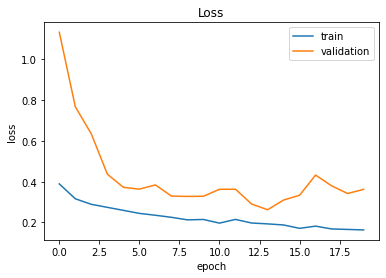

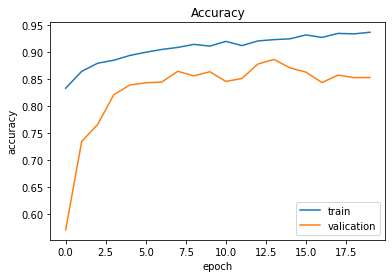

In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'selu'
loss = 'binary_crossentropy'
metrics = ['accuracy']
n_epochs = 20

# pretrained model
def feature_extractor(inputs):
  features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights='imagenet')(inputs)
  return features

def classifier(inputs):
  # connector
  x = BatchNormalization()(inputs)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  
  # additional layers
  x = Dense(1024, activation=act)(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation=act)(x)
  x = BatchNormalization()(x)
  output = Dense(2, activation='sigmoid', name='predictions')(x)
  return output

# build model
def selu_mobileNet2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
  n_classes = n_class
  input_shape = input_shape
  model_name = 'selu_mobileNet2'

  feature_mobileNet = feature_extractor(inputs)
  class_output = classifier(feature_mobileNet)

  model = Model(inputs=inputs, outputs=class_output, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
  return model

# define input layer
inputs = Input(shape=(96,96,3))
selu_mobileNet2 = run_all(selu_mobileNet2(inputs))

## M2: elu_mobileNet2 (90%)

Epoch 1/20
308/308 [==============================] - 61s 181ms/step - loss: 0.3573 - accuracy: 0.8506 - auc_21: 0.9242 - precision_21: 0.8469 - recall_21: 0.8450 - true_negatives_21: 16649.0000 - true_positives_21: 16605.0000 - val_loss: 0.8888 - val_accuracy: 0.6965 - val_auc_21: 0.7949 - val_precision_21: 0.6951 - val_recall_21: 0.7056 - val_true_negatives_21: 4463.0000 - val_true_positives_21: 4561.0000
Epoch 2/20
308/308 [==============================] - 54s 175ms/step - loss: 0.2527 - accuracy: 0.8941 - auc_21: 0.9613 - precision_21: 0.8919 - recall_21: 0.8927 - true_negatives_21: 17523.0000 - true_positives_21: 17541.0000 - val_loss: 0.8577 - val_accuracy: 0.7389 - val_auc_21: 0.8242 - val_precision_21: 0.7378 - val_recall_21: 0.7420 - val_true_negatives_21: 4760.0000 - val_true_positives_21: 4796.0000
Epoch 3/20
308/308 [==============================] - 54s 176ms/step - loss: 0.2225 - accuracy: 0.9112 - auc_21: 0.9698 - precision_21: 0.9094 - recall_21: 0.9104 - true_negative

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 3s 24ms/step - loss: 0.2412 - accuracy: 0.9011 - auc_21: 0.9652 - precision_21: 0.8992 - recall_21: 0.9007 - true_negatives_21: 5892.0000 - true_positives_21: 5903.0000


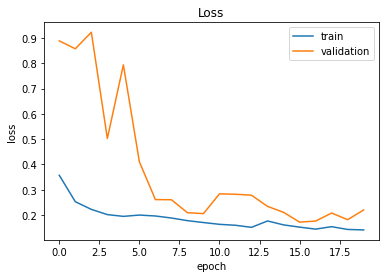

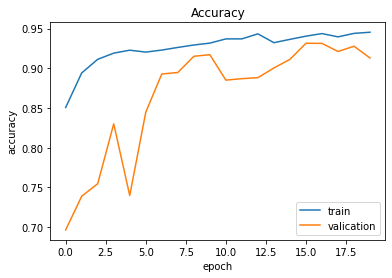

In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'elu'
loss = 'binary_crossentropy'
metrics = ['accuracy']
n_epochs = 20

# pretrained model
def feature_extractor(inputs):
  features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights='imagenet')(inputs)
  return features

def classifier(inputs):
  # connector
  x = BatchNormalization()(inputs)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  
  # additional layers
  x = Dense(1024, activation=act)(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation=act)(x)
  x = BatchNormalization()(x)
  output = Dense(2, activation='sigmoid', name='predictions')(x)
  return output

# build model
def elu_mobileNet2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
  n_classes = n_class
  input_shape = input_shape
  model_name = 'elu_mobileNet2'

  feature_mobileNet = feature_extractor(inputs)
  class_output = classifier(feature_mobileNet)

  model = Model(inputs=inputs, outputs=class_output, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
  return model

# define input layer

elu_mobileNet2 = run_all(elu_mobileNet2())

In [ ]:
m2.summary()

Model: "elu_mobileNet2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 batch_normalization_12 (Bat  (None, 3, 3, 1280)       5120      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_10 (Flatten)        (None, 1280)              0         
                                                    

## M3: relu_mobileNet2 (89%)

Epoch 1/20
308/308 [==============================] - 60s 180ms/step - loss: 0.3367 - accuracy: 0.8520 - auc_22: 0.9302 - precision_22: 0.8528 - recall_22: 0.8507 - true_negatives_22: 16764.0000 - true_positives_22: 16716.0000 - val_loss: 1.8595 - val_accuracy: 0.5650 - val_auc_22: 0.6652 - val_precision_22: 0.5643 - val_recall_22: 0.5668 - val_true_negatives_22: 3635.0000 - val_true_positives_22: 3664.0000
Epoch 2/20
308/308 [==============================] - 54s 174ms/step - loss: 0.2293 - accuracy: 0.9066 - auc_22: 0.9679 - precision_22: 0.9065 - recall_22: 0.9060 - true_negatives_22: 17814.0000 - true_positives_22: 17803.0000 - val_loss: 1.9367 - val_accuracy: 0.5647 - val_auc_22: 0.6605 - val_precision_22: 0.5659 - val_recall_22: 0.5676 - val_true_negatives_22: 3650.0000 - val_true_positives_22: 3669.0000
Epoch 3/20
308/308 [==============================] - 53s 174ms/step - loss: 0.1975 - accuracy: 0.9224 - auc_22: 0.9760 - precision_22: 0.9226 - recall_22: 0.9217 - true_negative

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


103/103 [==============================] - 2s 22ms/step - loss: 0.3609 - accuracy: 0.8898 - auc_22: 0.9493 - precision_22: 0.8891 - recall_22: 0.8904 - true_negatives_22: 5826.0000 - true_positives_22: 5836.0000


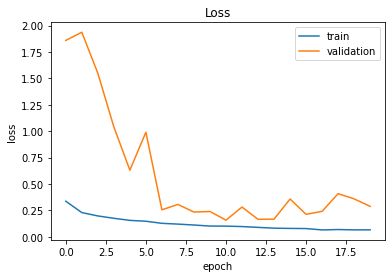

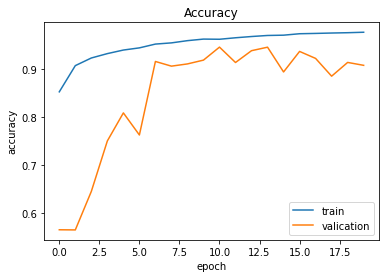

In [ ]:
(IMG_W, IMG_H, IMG_C) = (96,96,3)

# default config
lr = 0.0001
opt = Adam(learning_rate=lr)
act = 'relu'
loss = 'binary_crossentropy'
metrics = ['accuracy']
n_epochs = 20 

# pretrained model
def feature_extractor(inputs):
  features = MobileNetV2(
      input_shape = (IMG_W, IMG_H, IMG_C),
      include_top = False,
      weights='imagenet')(inputs)
  return features

def classifier(inputs):
  # connector
  x = layers.GlobalAveragePooling2D()(inputs)
  x = layers.Flatten()(x)
  
  # additional layers
  x = layers.Dense(1024, activation=act)(x)
  x = layers.Dense(512, activation=act)(x)
  
  output = layers.Dense(2, activation='sigmoid', name='predictions')(x)
  return output

# build model
def relu_mobileNet2(input_shape=(IMG_W, IMG_H, IMG_C), n_class=2):
  n_classes = n_class
  input_shape = input_shape
  model_name = 'relu_mobileNet2'

  feature_mobileNet = feature_extractor(inputs)
  class_output = classifier(feature_mobileNet)

  model = Model(inputs=inputs, outputs=class_output, name=model_name)
  model.compile(loss=loss, optimizer = opt, metrics= metrics)
  
  return model

# relu
relu_mobileNet2 = run_all(relu_mobileNet2())

# Evaluation

In [ ]:
# base + top 4
m0 = mobileNet2NN
m3 = relu_mobileNet2
m2 = elu_mobileNet2
m6 = relu_mobileNet2_lstm
m7 = elu_mobileNet2_lstm
e1 = ensembling

model_list = [m0, m3, m2, m6, m7, e1]

In [ ]:
m0_mx = [loss, accuracy, auc, precision, recall, tn, tp] = m0.evaluate(test_generator)
m3_mx = [loss, accuracy, auc, precision, recall, tn, tp] = m3.evaluate(test_generator)
m2_mx = [loss, accuracy, auc, precision, recall, tn, tp] = m2.evaluate(test_generator)
m6_mx = [loss, accuracy, auc, precision, recall, tn, tp] = m6.evaluate(test_generator)
m7_mx = [loss, accuracy, auc, precision, recall, tn, tp] = m7.evaluate(test_generator)
e1_mx = [loss, accuracy, auc, precision, recall, tn, tp] = e1.evaluate(test_generator)

103/103 [==============================] - 14s 133ms/step - loss: 0.2077 - accuracy: 0.9371 - auc_16: 0.9808 - precision_16: 0.9381 - recall_16: 0.9368 - true_negatives_16: 6149.0000 - true_positives_16: 6140.0000
